# 1. VGG16 모델
: 영상의 내용을 참고하여 직접 코드로 모델을 구현
* Batch Normalization, Parameter Initialization 등을 사용할 수도 있습니다.

<br>skip connection, pre-trained model 등 다양한 방법을 사용하여 기본적인 VGG16 모델의 성능보다 높은 정확도를 구해보세요.



In [1]:
# 필요한 라이브러리를 불러오기

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

* 캐글에서 제공되는 개와 고양이의 데이터로, 이번 프로젝트에서 우리는 개와 고양이를 분류할 예정입니다. test 데이터에서 1은 개, 0은 고양이를 의미

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
#train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

C:\Users\sunw0506\.keras\datasets\cats_and_dogs_filtered\train
C:\Users\sunw0506\.keras\datasets\cats_and_dogs_filtered\validation


In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

C:\Users\sunw0506\.keras\datasets\cats_and_dogs_filtered\train\cats
C:\Users\sunw0506\.keras\datasets\cats_and_dogs_filtered\train\dogs
C:\Users\sunw0506\.keras\datasets\cats_and_dogs_filtered\validation\cats
C:\Users\sunw0506\.keras\datasets\cats_and_dogs_filtered\validation\dogs


In [5]:
#train 데이터와 validation 데이터의 개수 알아보기

num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [6]:
# parameter Initialization
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [7]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

* train 데이터가 2천장 밖에 되지 않기 때문에 Data Augmentation(데이터 증강)을 통해 데이터의 수를 늘립니다.

**Data Augmentation**
* Rescale, Rotation
* Random Crop
* Zoom
* Flip 

등 다양한 기법을 사용하여 데이터의 양을 증가

In [8]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

* .flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결
* 우리는 개와 고양이를 분류하는 task를 수행하기 때문에class_mode는 'binary'
* Classification task에 따라 class_mode를 변경

In [9]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [10]:
# Data Augmentation이 제대로 되었는지 확인

train_data_gen[0][0].shape

(16, 256, 256, 3)

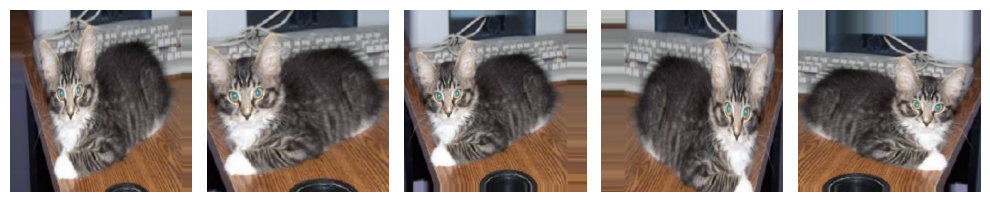

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [12]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

* Validation 데이터에도 train 데이터와 같은 동일한 작업
* Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경

In [13]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


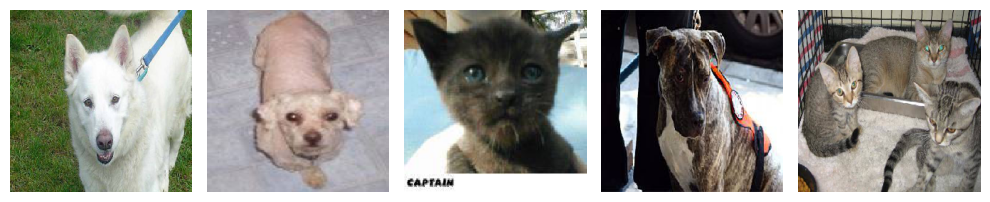

In [14]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [41]:
_[:5] # 정답 데이터

array([1., 0., 1., 1., 0.], dtype=float32)

## 문제 1-1. VGG16 모델 구현하기


In [42]:
# 참고 코드 변형 

input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)


x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(1000, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 128)     1475

In [43]:
# 손실함수, optimizer, metric을 설정해 줍니다.

loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

* data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환함.
* batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 전달해야 함
* batch_size=20이고 steps_per_epoch=100일 경우 (데이터, 라벨)의 쌍 20개가 생성되고, 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료 (단, 크기 20의 batch 데이터는 매번 랜덤으로 생성)

In [19]:
# 모델 학습

history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 62s 377ms/step - loss: 388.7054 - binary_accuracy: 0.5000 - val_loss: 81.8355 - val_binary_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 44s 350ms/step - loss: 0.7648 - binary_accuracy: 0.5000 - val_loss: 1.9539 - val_binary_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 44s 347ms/step - loss: 0.7563 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 4/5
125/125 [==============================] - 43s 342ms/step - loss: 0.7573 - binary_accuracy: 0.5000 - val_loss: 0.6945 - val_binary_accuracy: 0.5000
Epoch 5/5
125/125 [==============================] - 43s 345ms/step - loss: 36.5665 - binary_accuracy: 0.5000 - val_loss: 45499.1719 - val_binary_accuracy: 0.5000


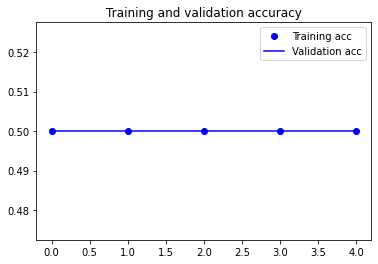

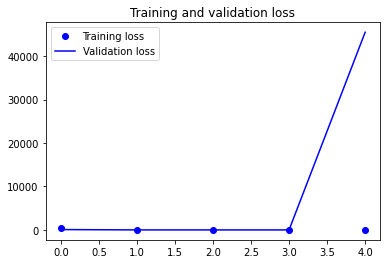

In [20]:
# 시각화 

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기
: hyperparameter 변경, 모델 수정, optimizer 변경, skip connection, pre-trained model 등 다양한 방법을 사용하면 모델의 성능을 높일 수 있습니다. 다양한 실험을 통해 성능을 올려 보세요.

In [15]:
# 문제 1-2. hyperparameter 설정
# parameter Initialization (batch size 조정 )
batch_size = 100
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [16]:
# 문제 1-2. 데이터 generator 생성
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)


train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')


Found 2000 images belonging to 2 classes.


In [17]:
# 문제 1-2. 모델 구현 (layer 채널 및 개수 조절, dropout 추가)
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)


x=tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(1000, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496 

In [18]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일 (optimizer=RMSprop 로 변경 )

loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.RMSprop(learning_rate=0.001)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]


In [77]:
# 모델 학습
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5


ResourceExhaustedError:  OOM when allocating tensor with shape[100,32,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_6/conv2d_46/Relu (defined at tmp/ipykernel_621/1581164475.py:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_17345]

Function call stack:
train_function


In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

---
**회고**

이번 노드는 파라미터 수가 많아서 그런지 학습을 진행하는데 커널이 자꾸 종료가 되어 진행하는데 힘이 들었다. 
그래서 상태를 변경시켜 학습을 시키는데도 많은 변수를 조절하지는 못했던 것 같다. 

LMS 와 코랩 두 군데서 모두 같은 현상을 보여 앞으로 진행할 학습환경에 GPU 및 환경 설정을 찾아 변경을 좀 해봐야할 것 같다. 